<a href="https://colab.research.google.com/github/c-Tos1wa/pytorch/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construção de uma rede neural

In [1]:
import os
import torch
from torch import nn #oferece todos os pacotes necessários para construir uma rede neural
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #verifica se GPU está disponível, caso contrário utiliza cpu
print(f"Using {device}")

Using cpu


In [3]:
# Definição da rede neural e inicializa as camadas em __init__
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

#Neste método é implementado as operaçÕes nos dados de entrada
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


In [4]:
#Instancia a classe, coloca no 'device' e printa a sua estrutura
n_network = NeuralNetwork().to(device)
print(n_network)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
example = torch.rand(2, 28, 28, device = device)
logits = n_network(example)
pred_probab = nn.Softmax(dim=1)(logits)
prediction = pred_probab.argmax(1)
print(f"Predicted class: {prediction}")

Predicted class: tensor([4, 7])


obs: Passing input data on the model will return a 2D tensor with dim = 0 corresponding to each output of 10 raw predicted values for each class, and dim = 1 corresponds to the individual values of each output. The prediction probability is shown by passing it through an instance of the nn.Softmax module.

--------------------------------------------------------------------------------

## Treinamento de uma rede neural

In [6]:
import requests
import pickle
import gzip
import numpy as np
from pathlib import Path
from matplotlib import pyplot

(50000, 784)


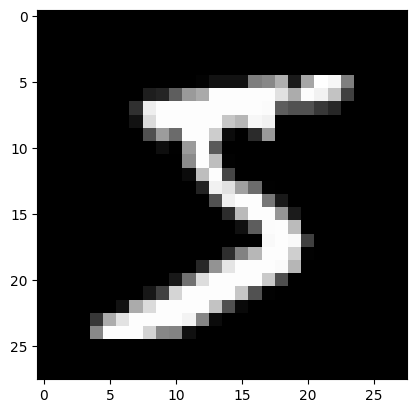

In [7]:
# Estabelece conexão com o arquivo de dados MNIST e faz requests por tais dados
DATA_PATH = Path("data")
PATH = DATA_PATH/"mnist"

PATH.mkdir(parents=True, exist_ok=True)

url = "https://github.com/pytorch/tutorials/raw/main/_static/"
filename = "mnist.pkl.gz"

if not (PATH/filename).exists():
  content = requests.get(url + filename).content
  (PATH/filename).open("wb").write(content)

# Dataset está armazenado em formato numpy array e usando pickle (formato específico Python p/ dados serializados)
with gzip.open((PATH/filename).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = "latin-1")

# Cada imagem está armazenada como um linha de comprimento 784 (o tamanho de cd imagem é 28x28).
# Para poder visualizar, primeiro transforma-a em 2D.
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
try:
  import google.colab
except ImportError:
  pyplot.show()
print(x_train.shape)

In [8]:
import torch

In [9]:
#transforma o dataset em torch.tensor, que é a "unidade básica"do Pytorch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(f"x_train: {x_train}")
print(f"y_train: {y_train}")
print(f"formato de x_train: {n, c}")
print(y_train.min(), y_train.max())

x_train: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
y_train: tensor([5, 0, 4,  ..., 8, 4, 8])
formato de x_train: (50000, 784)
tensor(0) tensor(9)


<https://pytorch.org/tutorials/beginner/nn_tutorial.html>

## Uso dos módulos e classes de <code>torch.nn.functional</code>

1. Sem <code>torch.nn</code>

In [10]:
import math

In [11]:
# Pesos são inicializados como números aleatórios multiplcados por 1/sqrt(n)
# Bias inicializados como tensor de 0 e então coloca-se um gradiente p/ ser calculado durante backpropagation
weights = torch.randn(784, 10)/math.sqrt(784)
weights.requires_grad_() # _ significa que a operação é feita "in-place"
bias = torch.zeros(10, requires_grad = True)

In [12]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias) # '@' => simboliza multiplicação de matrizes

In [13]:
batch = 64
xb = x_train[0:batch]
pred = model(xb)
pred[0], pred.shape
print(f"Tensor inicial: {pred[0]} \n Formato: {pred.shape}")

Tensor inicial: tensor([-2.2408, -3.1888, -2.3421, -2.8364, -2.3449, -2.1744, -2.7663, -1.7999,
        -1.8081, -2.3441], grad_fn=<SelectBackward0>) 
 Formato: torch.Size([64, 10])


In [14]:
# Função de custo/perda
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0:batch]
print(loss_func(pred, yb))

tensor(2.4219, grad_fn=<NegBackward0>)


In [15]:
#cálculo da precisão do modelo
def acc(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

#print(f"Exatidão: {acc(pred, yb)}")
print(acc(pred, yb))

tensor(0.0469)


In [16]:
# Criação de um training loop
from IPython.core.debugger import set_trace

learning_rate = 0.5
epochs = 2

for epoch in range(epochs):
  for i in range((n-1) // batch + 1):
    start_i = i * batch
    end_i = start_i + batch
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()

    with torch.no_grad():
      weights -= weights.grad * learning_rate
      bias -= bias.grad * learning_rate
      weights.grad.zero_()
      bias.grad.zero_()

Gradientes são usados para atualizar os pesos e bias. E essas ações não serão gravadas no próximo cálculo do gradiente, já que <code>torch.no_grad()</code>.
Depois, faz-se com que o gradiente retorne a ser um tensor composto por 0.

obs: Este é um **modelo de regressão logística**.

In [17]:
print(f"Função de perda: {loss_func(model(xb), yb)} \n Exatidão: {acc(model(xb), yb)}")

Função de perda: 0.0805879533290863 
 Exatidão: 1.0


2. Com <code>torch.nn</code>

In [18]:
import torch.nn.functional as F

In [19]:
loss_func = F.cross_entropy

def model(xb):
  return xb @ weights + bias

In [20]:
#print(f"Função de perda: {loss_func(model(xb), yb)} \n Exatidão: {acc(model(xb), yb)}")
print(loss_func(model(xb), yb), acc(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward0>) tensor(1.)


In [21]:
from torch import nn

In [22]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))
  def forward(self, xb):
    return xb @ self.weights + self.bias

model = Mnist_Logistic()

obs: Cria-se uma classe usando a subclasse <code>nn.Module</code> contendo todos os parâmetros que serão usados no treinamento dos loops.

In [23]:
print(loss_func(model(xb), yb))

tensor(2.3027, grad_fn=<NllLossBackward0>)


In [24]:
#epochs = 3
def train_loop():
  for epoch in range(epochs):
    for i in range((n - 1) // batch + 1):
      start = i * batch
      end = start + batch
      xb = x_train[start:end]
      yb = y_train[start:end]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()

      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * learning_rate
        model.zero_grad()

train_loop()

Com <code>torch.no_grad()</code>  e <code>model.parameters</code> não é preciso atualizar os parâmetors manualmente, tornando o treino mais conciso e com menos propensão ao erro.

In [25]:
print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward0>)


In [26]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.linnear = nn.Linear(784, 10)

  def forward(self, xb):
    return self.linnear(xb)

model_refac = Mnist_Logistic()

Refatora-se o código usando uma classe do Pytorch <code>nn.Linear</code>, que define e inicializa as variáveis, pesos e bias e calcula a função forward. Isso simplifica o algoritmo e "acelera" o processo.

In [27]:
print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward0>)


In [28]:
train_loop()
print(loss_func(model(xb), yb))

tensor(0.0661, grad_fn=<NllLossBackward0>)


In [29]:
from torch import optim

In [30]:
# Uso do passo "step" do optimizer para atualizar cada parâmetro automaticamente
def get_model():
  model_optim = model_refac
  return model_optim, optim.SGD(model_optim.parameters(), lr = learning_rate)

model_optim, opt = get_model()
print(loss_func(model_optim(xb), yb))

for epoch in range(epochs):
  for i in range((n - 1) // batch + 1):
    start = i * batch
    end = start + batch
    xb = x_train[start:end]
    yb = y_train[start:end]
    pred = model_optim(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model_optim(xb), yb))

tensor(2.3292, grad_fn=<NllLossBackward0>)
tensor(0.0815, grad_fn=<NllLossBackward0>)


2.1 Usando Dataset

In [31]:
from torch.utils.data import TensorDataset

<code>TensorDataset</code> é uma classe do Dataset e ele envolve tensores, facilitando na hora de iterar, indexar e dividir em pedaços (slice) as variáveis independentes e dependentes de treino.

In [32]:
train_ds = TensorDataset(x_train, y_train)

"""em vez de
xb = x_train[start:end]
yb = y_train[start:end]"""

xb, yb = train_ds[i*batch:i*batch+batch]

In [33]:
model_optim, opt = get_model()

for epoch in range(epochs):
  for i in range((n - 1)//batch + 1):
    xb, yb
    pred = model_optim(xb)
    loss = loss_func(pred, yb)

    loss.backward()

    opt.step()
    opt.zero_grad()

print(loss_func(model_optim(xb), yb))

tensor(0.0004, grad_fn=<NllLossBackward0>)


2.2 Usando DataLoader

In [34]:
from torch.utils.data import DataLoader

<code>DataLoader</code> gerencia batches. Ao criar um DataLoader de um Dataset, é mais fácil iterar batches e nos traz cada minibatch automaticamente.

In [35]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = batch)

In [36]:
model_optim, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model_optim(xb)
    loss = loss_func(pred, yb)

    loss.backward()

    opt.step()
    opt.zero_grad()

print(loss_func(model_optim(xb), yb))

tensor(0.0434, grad_fn=<NllLossBackward0>)


In [37]:
# Validação
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = batch, shuffle = True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size = batch*2)

In [38]:
model_optim, opt = get_model()

for epoch in range(epochs):
  model_optim.train()
  for xb, yb in train_dl:
    pred = model_optim(xb)
    loss = loss_func(pred, yb)

    loss.backward()

    opt.step()
    opt.zero_grad()

  model_optim.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model_optim(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2822)
1 tensor(0.3259)
